In [186]:
import numpy as np
import astropy.units as u
import astropy.constants as c

import matplotlib.pyplot as plt

import mesaPlot as mp
import mesa_reader as mr


def prepare_canvas():
    plt.rcParams['figure.figsize'] = [15, 10]
    plt.rcParams['axes.linewidth'] = 2.5
    plt.legend(prop={'size': 15})
    
    fontsize = 20
    ax = plt.gca()
    ax.tick_params(direction='in',length=5)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        #tick.label1.set_fontweight('bold')
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        #tick.label1.set_fontweight('bold')

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


In [170]:
def vrel(m01,m02,a0):
             return ((c.G*(m01+m02)/a0)**0.5).to(u.km/u.s)


def af(a0,m01,m02,dm,w,theta=0*u.rad,phi=0*u.rad):
              m = m01+m02
              mf = m02-dm
              a = 1-dm/m
              v = vrel(m01,m02,a0)
              b = 1-2*dm/m - (w/v)**2 - 2*np.cos(theta)*(w/v)
              af = a0*(a/b)
              P = 0.5*(1 + ((1-2*dm/m-(w/v)**2)/(2*(w/v))))
              Pa = 0.5 - (((dm/m) + (w/v)**2)/(4*(w/v)))
              emin = (m01-m02+dm)/(2*dm)
              mu = m01*(m02-dm)/(m01+m02-dm)
              Ef = - c.G*m01*mf*0.5/af
              Lf = a0*mu*((v+w*np.cos(theta))**2. + (w*np.sin(theta)*np.sin(phi))**2)**0.5
              e  = (1 + (2*Ef*Lf**2)/(mu*c.G**2 *m01**2 * mf **2))**0.5
              return af,P,Pa,emin,e

In [171]:
ch1_mine_1200=af(0.03*u.AU,21.4*u.Msun,20*u.Msun,
                 17.5*u.Msun,1200*u.km/u.s,
                 np.random.uniform(0.,4*np.pi,10000)*u.rad,np.random.uniform(0.,4*np.pi,10000))

ch1_zevin_160=af(1.1*u.AU,21.6*u.Msun,7.7*u.Msun,
                 3.7*u.Msun,160*u.km/u.s,
                 np.random.uniform(0.,4*np.pi,10000)*u.rad,np.random.uniform(0.,4*np.pi,10000))

0.2644976472903757
0.4193126409471126


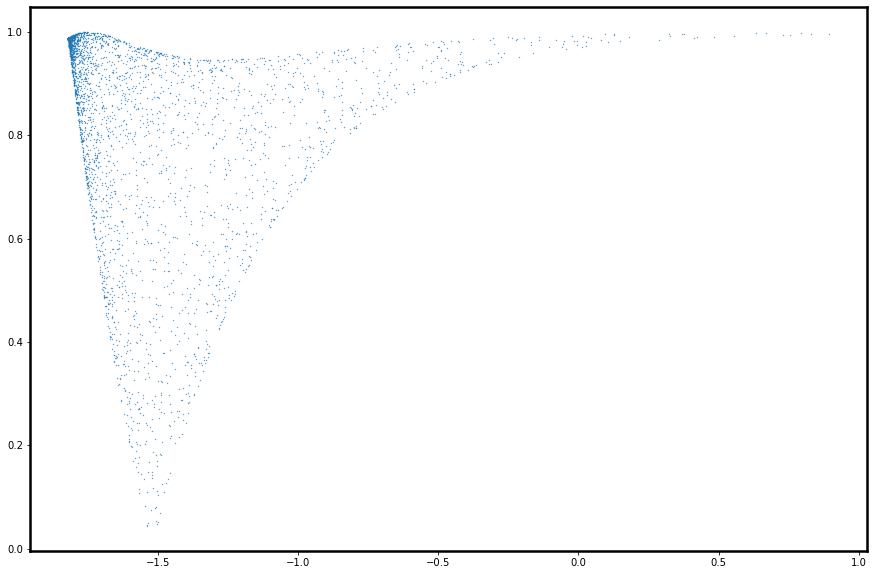

In [172]:
plt.scatter(np.log10(ch1_mine_1200[0][ch1_mine_1200[0]>0].value),ch1_mine_1200[4][ch1_mine_1200[0]>0],s=0.1)


print(ch1_mine_1200[1])
print(ch1_zevin_160[1])

In [173]:
def time_to_merge(a,e,m1,m2):
        m = m1+m2
        mu = m1*m2/(m1+m2)
        emax = e
        C0 = a*(1-e**2)/(e**(12./19.)) *(1+(121/304)*e**2)**(-870/2299)
        b = 64*c.G**3 * m**2 *mu /5 /c.c**5

        e = np.arange(0.0,emax,0.0001)
        
        X = e**(29/19) * (1 + (121/304)*e**2) **(1181/2299) / ((1-e**2)**(3/2.))
        
        X = (12/19)*C0**4/b * X
        tau=np.trapz(e,X)
        return tau.to(u.Myr)
    
def merger_threshold(a,m1,m2,Ht=13.8*u.Gyr):
    e_array = np.arange(0.,1.,0.001)
    t_merge = []
    for e in e_array:
        t = time_to_merge(a,e,m1,m2)
        t_merge.append(t.value)
    t_merge = np.array(t_merge)
    if t_merge.max() <= Ht.to(u.Myr).value:
        emin = 0.
    else:
        idmin = find_nearest(t_merge, Ht.to(u.Myr).value)
        emin = e_array[idmin]
    return emin

def threshold_curve(m1,m2):
    a_array = np.arange(0.01,3.,0.1)*u.AU
    e_array = []
    for a in a_array:
        e = merger_threshold(a,m1,m2)
        e_array.append(e)
    e_array = np.array(e_array)
    return a_array,e_array

def merger_time_for_many(a_array,e_array,m1,m2):
    merger_times=[]
    i = 0
    for i in range(len(a_array)):
        t=time_to_merge(a_array[i],e_array[i],m1,m2).value
        merger_times.append(t)
        i = i + 1
    merger_times = np.array(merger_times)
    return merger_times*u.Myr

In [174]:
time_to_merge(0.03*u.AU,0.4,21.4*u.Msun,2.5*u.Msun)
emin=merger_threshold(0.03*u.AU,21.4*u.Msun,2.5*u.Msun)
a_array,e_array=threshold_curve(21.4*u.Msun,2.5*u.Msun)

/Users/jantoniadis/opt/anaconda3/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


No handles with labels found to put in legend.


NameError: name 'mass_1' is not defined

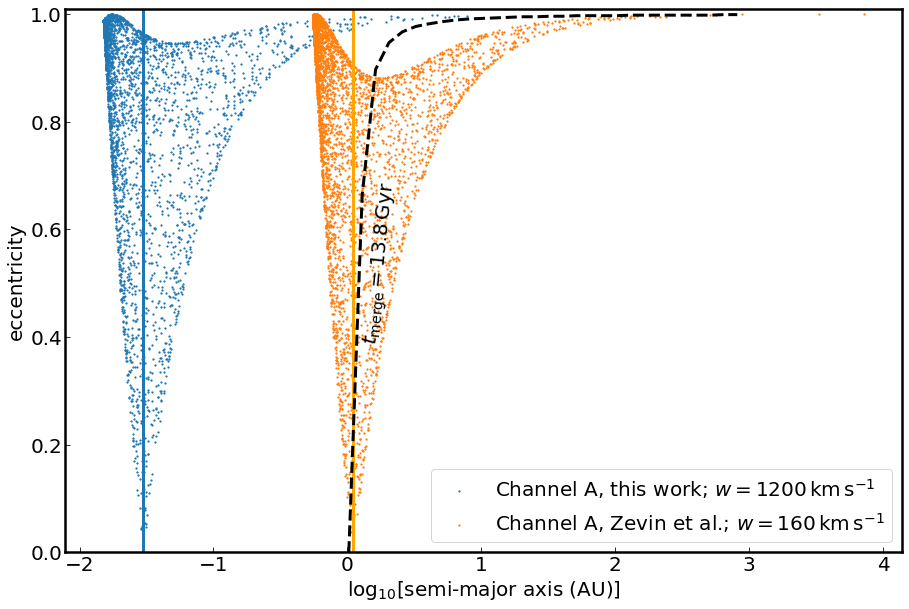

In [194]:
prepare_canvas()
plt.scatter(np.log10(ch1_mine_1200[0][ch1_mine_1200[0]>0].value),ch1_mine_1200[4][ch1_mine_1200[0]>0],s=1.5,label=r'Channel A, this work; $w=1200\,{\rm km\,s^{-1}}$')
plt.scatter(np.log10(ch1_zevin_160[0][ch1_zevin_160[0]>0].value),ch1_zevin_160[4][ch1_zevin_160[0]>0],s=1.5,label=r'Channel A, Zevin et al.; $w=160\,{\rm km\,s^{-1}}$')
plt.plot(a_array,e_array,color='black',lw=3,ls='--')
plt.vlines(np.log10(0.03),0,1.01,lw=3)
plt.vlines(np.log10(1.1),0,1.01,lw=3,color='orange')
plt.xlabel(r'$\log_{10}$[semi-major axis (AU)]',fontsize=20)
plt.ylabel('eccentricity',fontsize=20)
plt.legend(fontsize=20)
plt.ylim([0.0,1.01])
plt.text(0.1, 0.4, r'$t_{\rm merge}=13.8\,{\rm Gyr}$',rotation=84,fontsize=20)
plt.savefig('SN_kicks_comp.pdf')


In [175]:
mine=merger_time_for_many(ch1_mine_1200[0][ch1_mine_1200[0]>0],ch1_mine_1200[4][ch1_mine_1200[0]>0],21.4*u.Msun,2.5*u.Msun)

zevin=merger_time_for_many(ch1_zevin_160[0][ch1_zevin_160[0]>0],ch1_zevin_160[4][ch1_zevin_160[0]>0],21.4*u.Msun,2.5*u.Msun)

No handles with labels found to put in legend.


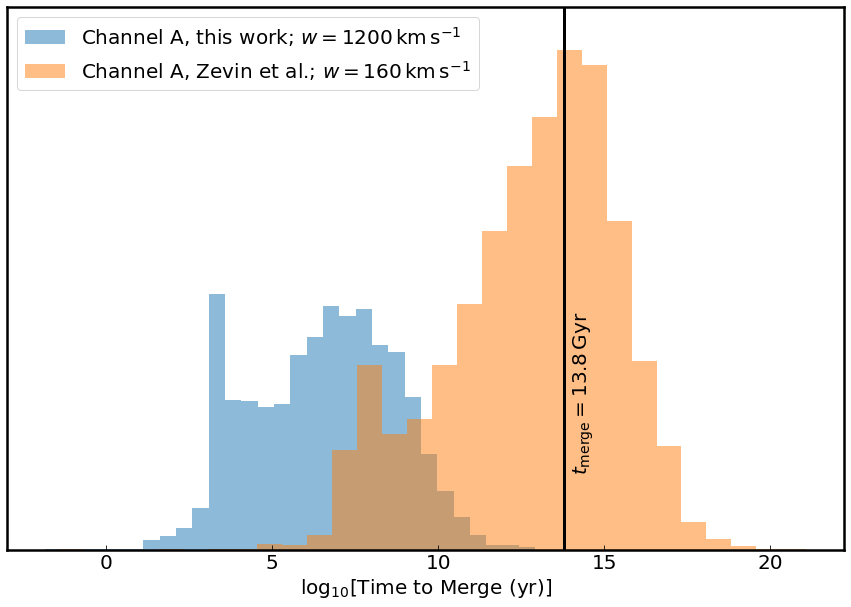

In [183]:
prepare_canvas()
plt.hist(np.log10(mine.to(u.yr).value),bins=30,label=r'Channel A, this work; $w=1200\,{\rm km\,s^{-1}}$',alpha=0.5)
plt.hist(np.log10(zevin.to(u.yr).value),bins=30,label=r'Channel A, Zevin et al.; $w=160\,{\rm km\,s^{-1}}$',alpha=0.5)
plt.legend(fontsize=20)
plt.yticks([])
plt.xlabel(r'$\log_{10}$[Time to Merge (yr)]',fontsize=20)
plt.vlines(np.log10(10**13.8),0,750,lw=3,color='black')
plt.ylim([0,650])

plt.text(14.0, 100, r'$t_{\rm merge}=13.8\,{\rm Gyr}$',rotation=90,fontsize=20)
plt.savefig('SN_kicks_comp_hist.pdf')

In [177]:
len(np.where(np.log10(mine.to(u.yr).value)<13.8)[0])/len(mine)

1.0

In [189]:
work_dir = '0.950_0.700/'

In [193]:
ls bhns_example/

LOGS1/                inlist2*              model2.dat*
LOGS2/                inlist_extra*         model2.dat.gz*
binary_history.hdf5*  inlist_pgstar*        out.txt.gz*
clean*                inlist_project*       plots.ipynb*
dir*                  make/                 profile_columns.list*
ev.sh*                mesainit.sh*          re*
history_columns.list* mk*                   rn*
inlist*               model1.dat*           src/
inlist1*              model1.dat.gz*        summary.txt*


In [200]:
ch1_mine_1200[0][ch1_mine_1200[0]<=0].shape

(6598,)

In [201]:
3402./(6598+3402)

0.3402